# General QR Optimizer for Spatial Constraints

This notebook explores the `PySensors` General QR `GQR` optimizer for spatially-constrained sparse sensor placement (for reconstruction).

Suppose we are interested in reconstructing a field based on a limited set of measurements due to constrained locations. Examples:

- Nuclear applications (estimating the temperature at different points inside a nuclear fuel rod where certain areas allow only a limited number of thermocouples)
- Fluid flows (approximating the temperature distribution of heat diffusion through a plate where no sensors are allowed near the heater )
- Sea-surface temperature (determining the locations of the rest of the sensors when two locations are predetermined to predict the temperature at any point on the ocean.)

In other notebooks we have shown how one can use the `SSPOR` class to pick optimal locations in which to place sensors to accomplish this task. But so far we have treated all sensor locations as being equally viable (`QR` optimizer). The cost-constrained QR (`CCQR` optimizer) determines the optimal placement of sensors based on the cost of placing a sensor in a certain location. What happens when some sensor locations allow only a limited number of sensors to be placed, predetermined locations are present or restricted areas exist within the physical attribute. 

The General QR algorithm was devised specifically to solve such problems. The `PySensors` object implementing this method is named `GQR` and in this notebook we'll demonstrate its use on a toy problem.

See the following reference for more information ([link](https://arxiv.org/abs/2306.13637))


    Niharika Karnik, Mohammad G. Abdo, Carlos E. Estrada Perez, Jun Soo Yoo, Joshua J. Cogliati, Richard S. Skifton, Pattrick Calderoni, Steven L. Brunton, and Krithika Manohar. Optimal Sensor Placement with Adaptive Constraints for Nuclear Digital Twins. 2023. arXiv: 2306 . 13637 [math.OC].

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

import pandas as pd
import pysensors as ps

from mpl_toolkits.axes_grid1 import make_axes_locatable

## Setup 

We'll consider the Olivetti faces dataset from AT&T. Our goal will be to reconstruct images of faces from limited number of sensors placed in certain constrained regions and predetermined locations. 

Loading and preprocessing the data:

In [2]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape
print('Number of samples:', n_samples)
print('Number of features (sensors):', n_features)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/yash6599/scikit_learn_data
Number of samples: 400
Number of features (sensors): 4096


In [3]:
# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

In [4]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

# Plot first few centered faces:
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    '''Function for plotting faces'''
    plt.figure(figsize=(5. * n_col, 5.5 * n_row))#2. * n_col, 2.26 * n_row
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                interpolation='nearest',
                vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

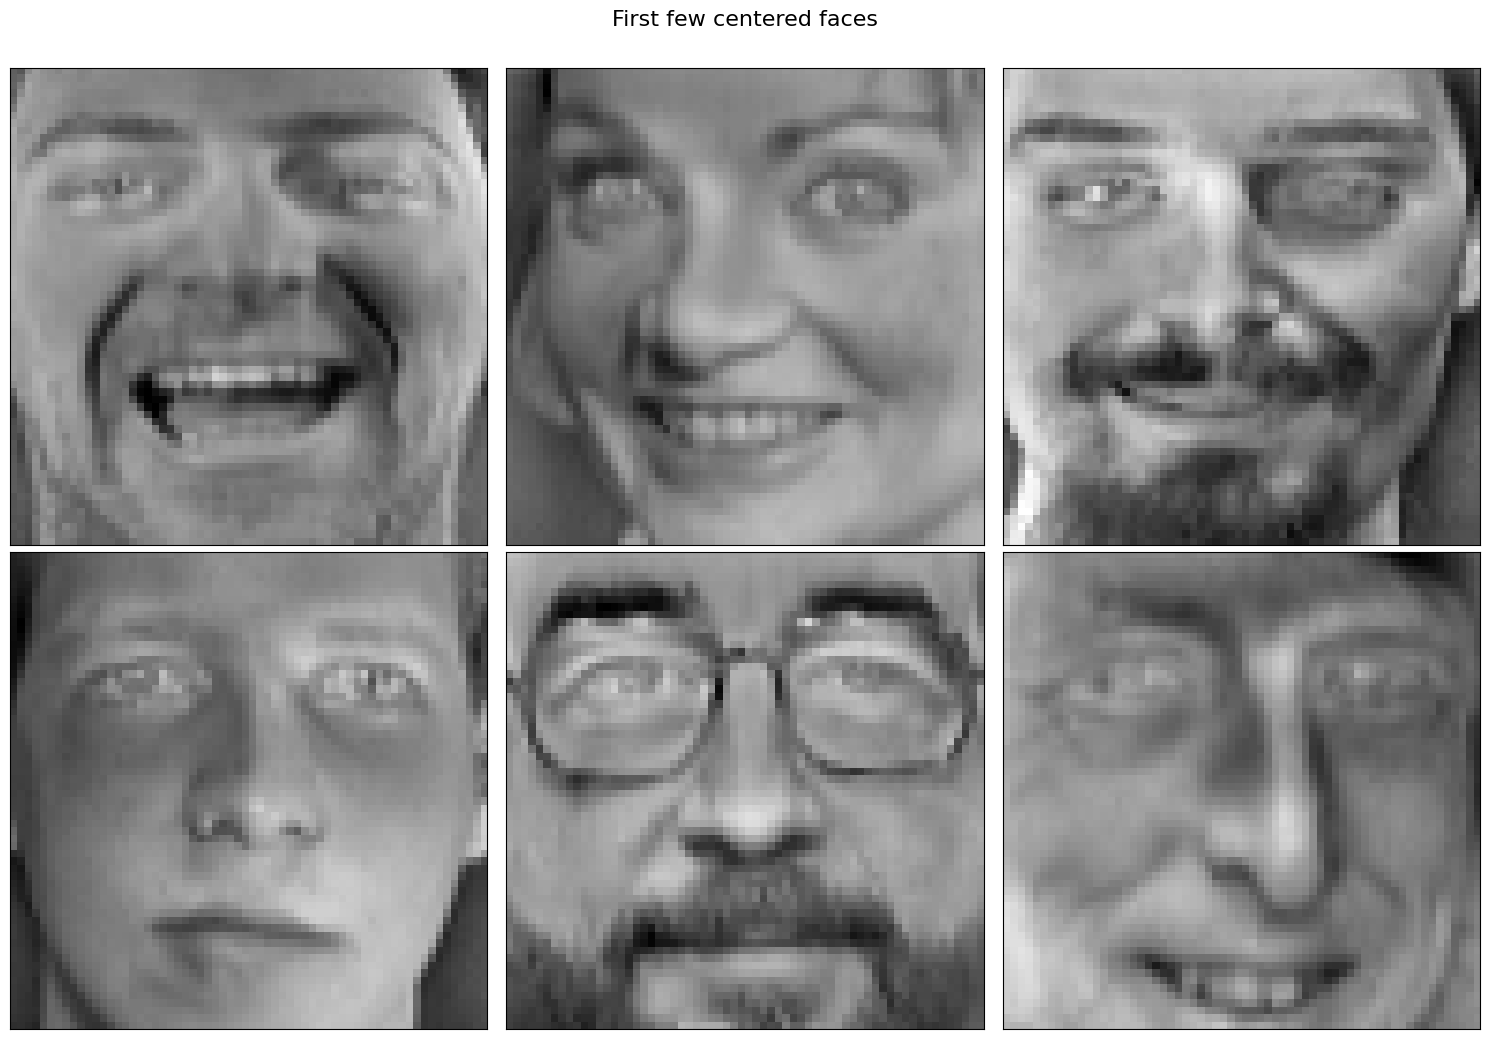

In [5]:
plot_gallery("First few centered faces", X[:n_components])

We'll learn the sensors using the first 300 faces and use the rest for testing reconstruction error.

In [6]:
X_train, X_test = X[:300], X[300:]

## Unconstrained optimization of sensor placement:

Consider the case where we treat all sensor locations as being equally viable.

In [7]:
n_sensors = 15
n_modes = 15

# Define the QR optimizer
optimizer_unconstrained = ps.optimizers.QR()
basis_unconstrained = ps.basis.SVD(n_basis_modes=n_sensors)

# Initialize and fit the model
model_unconstrained = ps.SSPOR(basis=basis_unconstrained,optimizer=optimizer_unconstrained, n_sensors=n_sensors)
model_unconstrained.fit(X_train)

all_sensors = model_unconstrained.get_all_sensors()

# sensor locations based on columns of the data matrix
top_sensors = model_unconstrained.get_selected_sensors() 

# sensor locations based on pixels of the image
xTopUnc = np.mod(top_sensors,np.sqrt(n_features))  
yTopUnc = np.floor(top_sensors/np.sqrt(n_features)) 
xAllUnc = np.mod(all_sensors,np.sqrt(n_features))
yAllUnc = np.floor(all_sensors/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors))

The list of sensors selected is: [2204 4038 3965  320  253  594 3618  878 2331 3999  429 2772 2878 3469
 1243]


The above cell shows sensor locations in terms of the column numbers chosen as sensors. 

These locations can be converted into the x and y position of a pixel on the image grid shown by xTopUnc and yTopUnc. 

In [8]:
#Sensor ID corresponds to the column number chosen
columns = ['Sensor ID','SensorX','sensorY'] 
unconstrainedSensors_df = pd.DataFrame(data = np.vstack([top_sensors,xTopUnc,yTopUnc]).T,columns=columns,dtype=int)
unconstrainedSensors_df.head(n_sensors)

,Sensor ID,SensorX,sensorY
0,2204,28,34
1,4038,6,63
2,3965,61,61
3,320,0,5
4,253,61,3
5,594,18,9
6,3618,34,56
7,878,46,13
8,2331,27,36
9,3999,31,62


Now if we want to place just two sensors in the constrained region defined as $20 \leq x \leq 40$  and $10 \leq y \leq 40$. 

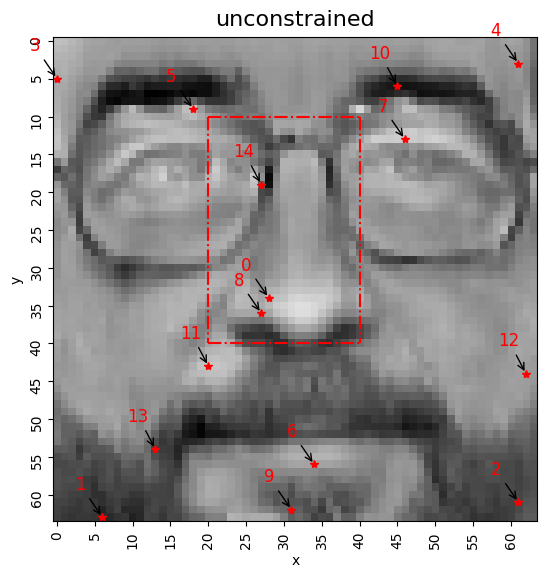

In [9]:
# Define our constrained region: 
xmin = 20
xmax = 40
ymin = 10
ymax = 40

# Plot the constrained region and the unconstrained sensors where 1 is the first sensor chosen.
image = X[4,:].reshape(1,-1)

plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
plt.plot([xmin,xmin],[ymin,ymax],'-.r')
plt.plot([xmin,xmax],[ymax,ymax],'-.r')
plt.plot([xmax,xmax],[ymin,ymax],'-.r')
plt.plot([xmin,xmax],[ymin,ymin],'-.r')
plt.plot(xTopUnc, yTopUnc,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.arange(0,64,5),rotation=90)
plt.yticks(np.arange(0,64,5),rotation=90)
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))

In [10]:
# Find the constrained sensor indices through the utils function
sensors_constrained = ps.utils._constraints.get_constrained_sensors_indices(xmin,xmax,ymin,ymax,image_shape[0],image_shape[1],all_sensors) #Constrained column indices 

There are three sensors placed by QR which lie within the constrained region, however only (n_const_sensors = 2) are allowed in that region. 

Two strategies have been developed to deal with this case: 

- exact_n : Number of sensors in the constrained region should be exactly equal to s. 
- max_n : Number of sensors in the constrained region should be less than or equal to s. 

## The exact_n case: 

In [11]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 2

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_exact = ps.optimizers.GQR()
opt_exact_kws={'idx_constrained':sensors_constrained,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors,
         'constraint_option':"exact_n"}
basis_exact = ps.basis.SVD(n_basis_modes=n_sensors)

In [12]:
# Initialize and fit the model
model_exact = ps.SSPOR(basis = basis_exact, optimizer = optimizer_exact, n_sensors = n_sensors)
model_exact.fit(X_train,**opt_exact_kws)

# sensor locations based on columns of the data matrix
top_sensors_exact = model_exact.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConst = np.mod(top_sensors_exact,np.sqrt(n_features))
yTopConst = np.floor(top_sensors_exact/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [2204 4038 3965  320  594  253  878 3618 2331 3999  429 2772 2878 3469
  211]


Display the unconstrained and constrained (GQR exact_n) sensor locations on the grid 

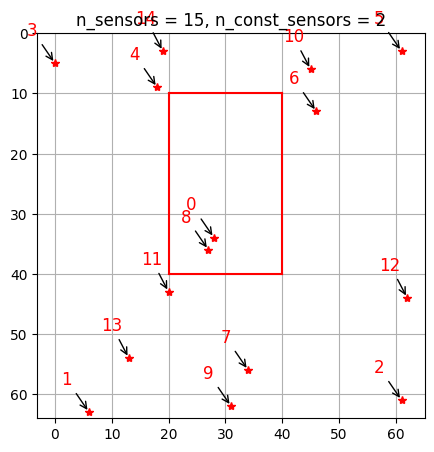

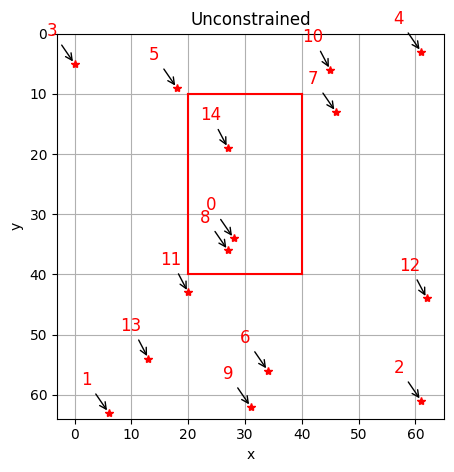

In [13]:
img = np.zeros(n_features)
img[top_sensors] = 16
plt.figure(figsize=(5,5))
plt.plot(xTopConst,yTopConst,'*r')
plt.plot([xmin,xmin],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymax,ymax],'r')
plt.plot([xmax,xmax],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymin,ymin],'r')
plt.ylim([64,0])
plt.title('n_sensors = {}, n_const_sensors = {}'.format(n_sensors,n_const_sensors))
for ind,i in enumerate(range(len(xTopConst))):
    plt.annotate(f"{str(ind)}",(xTopConst[i],yTopConst[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))
plt.grid()
plt.show()

plt.figure(figsize=(5,5))
plt.plot(xTopUnc, yTopUnc,'*r')
plt.plot([xmin,xmin],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymax,ymax],'r')
plt.plot([xmax,xmax],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymin,ymin],'r')
plt.title('Unconstrained')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([64,0])
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))
plt.grid()
plt.show()

Compare unconstrained vs. constrained (exact_n) sensor indices and pixel coordinates 

In [14]:
yConstrained = np.floor(top_sensors/np.sqrt(n_features))
xConstrained = np.mod(top_sensors,np.sqrt(n_features))

columns = ['Sensor ID','UncX','UncY','Sensor ID','XConst','YConst']
ConstrainedSensors_df = pd.DataFrame(data = np.vstack([top_sensors,xTopUnc,yTopUnc,top_sensors_exact,xConstrained,yConstrained]).T,columns=columns,dtype=int)
ConstrainedSensors_df.head(n_sensors)

,Sensor ID,UncX,UncY,Sensor ID,XConst,YConst
0,2204,28,34,2204,28,34
1,4038,6,63,4038,6,63
2,3965,61,61,3965,61,61
3,320,0,5,320,0,5
4,253,61,3,594,61,3
5,594,18,9,253,18,9
6,3618,34,56,878,34,56
7,878,46,13,3618,46,13
8,2331,27,36,2331,27,36
9,3999,31,62,3999,31,62


Plot sensor locations (pixels) on the image for unconstrained vs. constrained (exact_n)

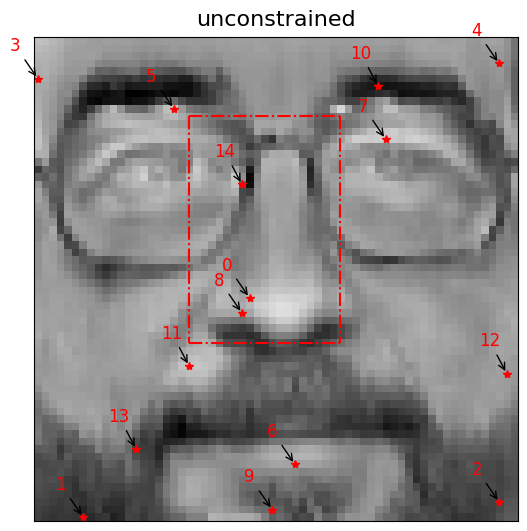

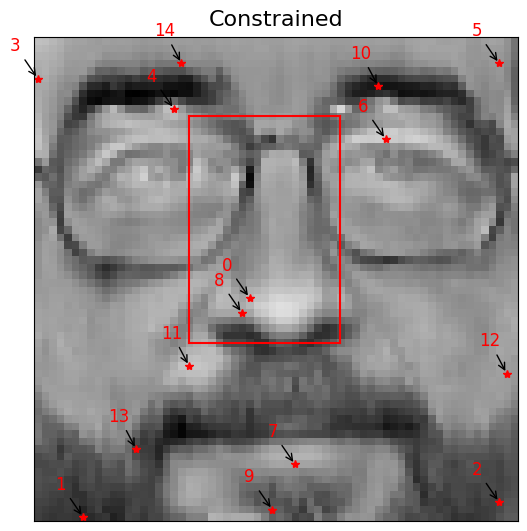

In [15]:
plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
yUnconstrained = np.floor(top_sensors/np.sqrt(n_features))
xUnconstrained = np.mod(top_sensors,np.sqrt(n_features))
plt.plot([xmin,xmin],[ymin,ymax],'-.r')
plt.plot([xmin,xmax],[ymax,ymax],'-.r')
plt.plot([xmax,xmax],[ymin,ymax],'-.r')
plt.plot([xmin,xmax],[ymin,ymin],'-.r')
plt.plot(xTopUnc, yTopUnc,'*r')
for i in (range(len(xTopUnc))):
    plt.annotate(f"{str(i)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))


plot_gallery('Constrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
plt.plot([xmin,xmin],[ymin,ymax],'-r')
plt.plot([xmin,xmax],[ymax,ymax],'-r')
plt.plot([xmax,xmax],[ymin,ymax],'-r')
plt.plot([xmin,xmax],[ymin,ymin],'-r')
plt.plot(xTopConst, yTopConst,'*r')
for i in (range(len(xTopConst))):
    plt.annotate(f"{str(i)}",(xTopConst[i],yTopConst[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))

## Reconstruct image from test set using sensors placed via constrained (exact_n) optimizer

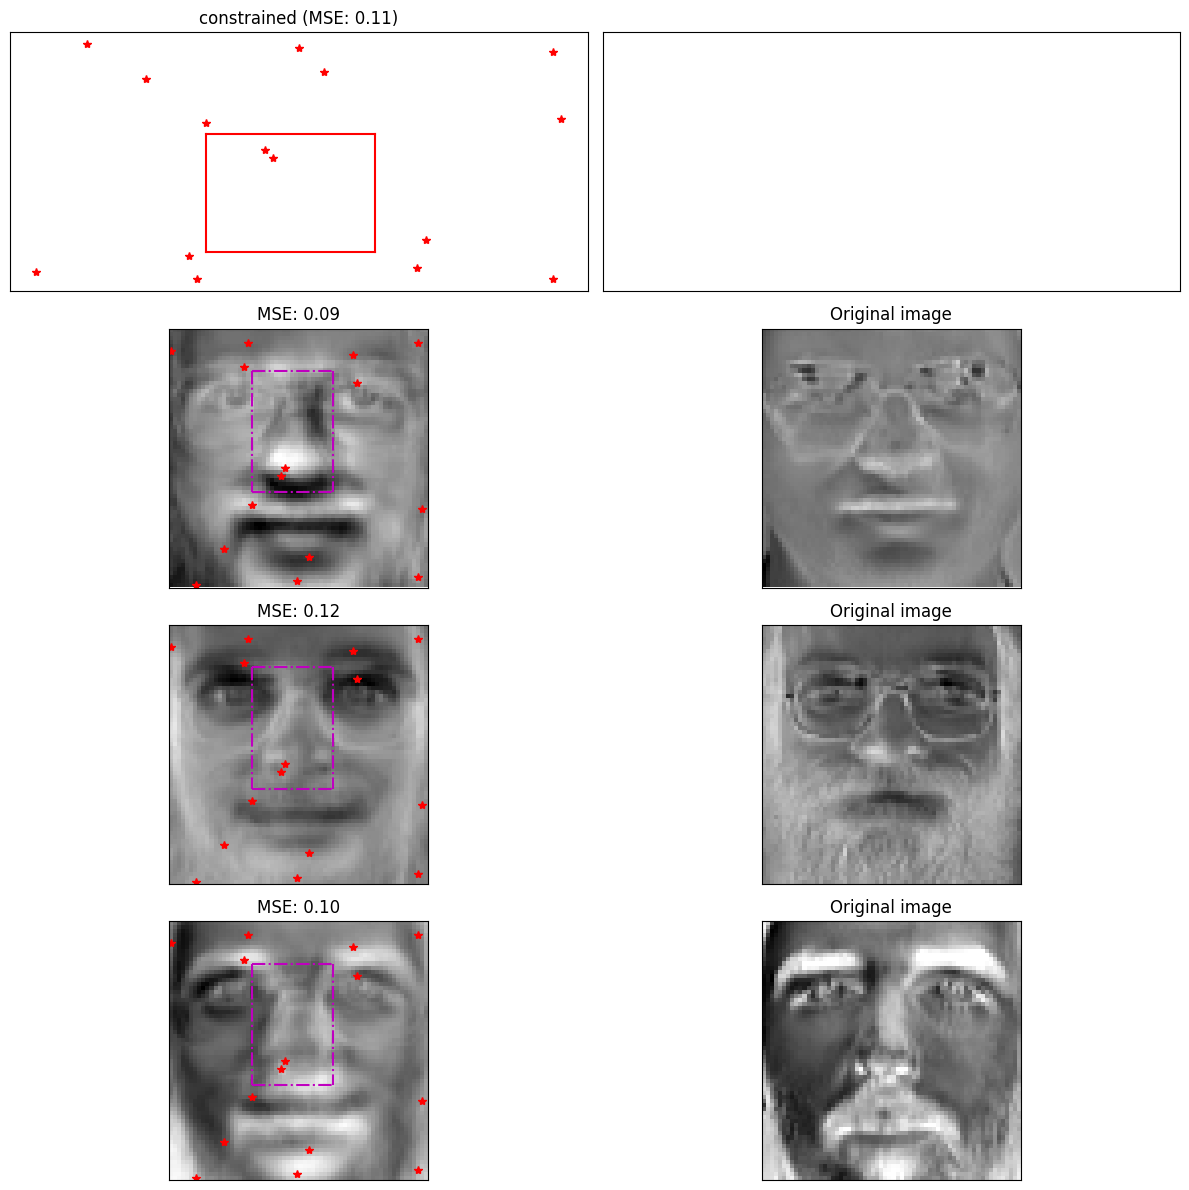

In [16]:
n_faces = 3
n_rows = n_faces + 1
n_cases = 1
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 3 * n_rows))

for k in range(n_cases):    
    # Get average reconstruction error across test set
    test_error = model_exact.reconstruction_error(X_test, sensor_range=[n_sensors])
    
    # Plot sensor locations

    axs[0, k].plot()
    axs[0, k].set(title=f"constrained (MSE: {test_error[0]:.2f})")
    axs[0, k].plot(xTopConst,yTopConst,'*r')
    axs[0, k].plot([xmin,xmin],[ymin,ymax],'r')
    axs[0, k].plot([xmin,xmax],[ymax,ymax],'r')
    axs[0, k].plot([xmax,xmax],[ymin,ymax],'r')
    axs[0, k].plot([xmin,xmax],[ymin,ymin],'r')

    # Plot reconstructed faces
    for j in range(n_faces):
        idx = 10 * j
        img = model_exact.predict(X_test[idx, top_sensors_exact])
        vmax = max(img.max(), img.min())
        axs[j + 1, k].imshow(
            img.reshape(image_shape),
            cmap=plt.cm.binary,
            vmin=-vmax,
            vmax=vmax
        )
        yConstrained = np.floor(top_sensors_exact/np.sqrt(n_features))
        xConstrained = np.mod(top_sensors_exact,np.sqrt(n_features))
        axs[j + 1, k].plot([xmin,xmin],[ymin,ymax],'-.m')
        axs[j + 1, k].plot([xmin,xmax],[ymax,ymax],'-.m')
        axs[j + 1, k].plot([xmax,xmax],[ymin,ymax],'-.m')
        axs[j + 1, k].plot([xmin,xmax],[ymin,ymin],'-.m')
        axs[j + 1, k].plot(xConstrained, yConstrained,'*r')

        error = model_exact.reconstruction_error(X_test[idx], sensor_range=[n_sensors])[0]
        axs[j + 1, k].set(title=f"MSE: {error:.2f}")
        
        # Plot target image
        true_img = X_test[idx]
        vmax = max(true_img.max(), true_img.min())
        axs[j + 1, k + 1].imshow(
            true_img.reshape(image_shape),
            cmap=plt.cm.binary,
            vmin=-vmax,
            vmax=vmax
        )
        axs[j + 1, k + 1].set(title="Original image")
        

[ax.set(xticks=[], yticks=[]) for ax in axs.flatten()]
fig.tight_layout()

### Compare reconstruction errors on test set for unconstrained vs. constrained exact_n sensor placement:

In [17]:
test_error_unconstrained = model_unconstrained.reconstruction_error(X_test, sensor_range=[n_sensors])
test_error_exact = model_exact.reconstruction_error(X_test, sensor_range=[n_sensors])
print("The reconstruction error for the unconstrained case is {}".format(test_error_unconstrained))
print("The reconstruction error for the constrained exact_n case is {}".format(test_error_exact))

The reconstruction error for the unconstrained case is [0.12289169]
The reconstruction error for the constrained exact_n case is [0.11311239]


### Observations: 
- Since unconstrained optimization places 3 sensors in the constrained region, the constrained optimization with n_const_sensors = 2 removes one sensor (ID 14) from the region and places it outside. 

- The drop in reconstruction error between the unconstrained and constrained optimization is $\mathcal{O} \approx 10^{-2}$. 

However, now if we want to place exactly 4 sensors in the constrained region, constrained exact_n will force the last sensor (ID 13) to be placed in the constrained region as shown below: 
- Note: As the 14th sensor already lies in the constrained region, the optimizer selects the second last sensor to lie in the constrained region. 

In [18]:
# Define the number of constrained sensors allowed (s)
n_const_sensors_exact = 4

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_exact1 = ps.optimizers.GQR()
opt_exact_kws1={'idx_constrained':sensors_constrained,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors_exact,
         'all_sensors':all_sensors,
         'constraint_option':"exact_n"}
basis_exact1 = ps.basis.SVD(n_basis_modes=n_sensors)

In [19]:
# Initialize and fit the model
model_exact1 = ps.SSPOR(basis = basis_exact1, optimizer = optimizer_exact1, n_sensors = n_sensors)
model_exact1.fit(X_train,**opt_exact_kws1)

# sensor locations based on columns of the data matrix
top_sensors_exact1 = model_exact1.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConst1 = np.mod(top_sensors_exact1,np.sqrt(n_features))
yTopConst1 = np.floor(top_sensors_exact1/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact1))

The list of sensors selected is: [2204 4038 3965  320  253  594  878 3618 2331 3999  429 2772 2878 1370
 1315]


Plot the sensor locations (pixels) on image for unconstrained and constrained exact_n

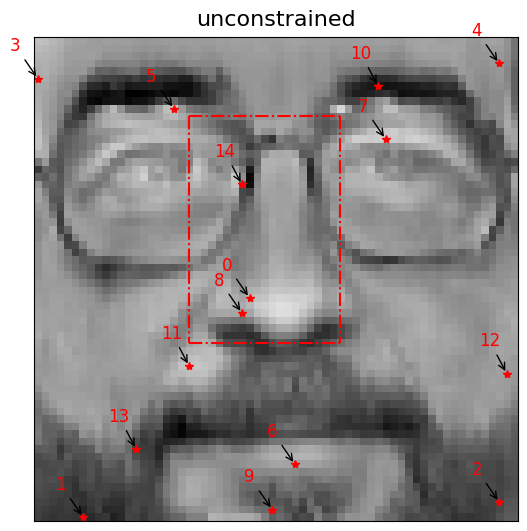

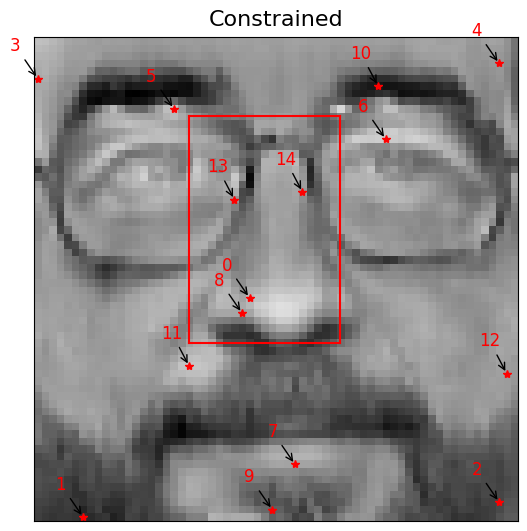

In [20]:
plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
yUnconstrained = np.floor(top_sensors/np.sqrt(n_features))
xUnconstrained = np.mod(top_sensors,np.sqrt(n_features))
plt.plot([xmin,xmin],[ymin,ymax],'-.r')
plt.plot([xmin,xmax],[ymax,ymax],'-.r')
plt.plot([xmax,xmax],[ymin,ymax],'-.r')
plt.plot([xmin,xmax],[ymin,ymin],'-.r')
plt.plot(xTopUnc, yTopUnc,'*r')
for i in (range(len(xTopUnc))):
    plt.annotate(f"{str(i)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))


plot_gallery('Constrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
plt.plot([xmin,xmin],[ymin,ymax],'-r')
plt.plot([xmin,xmax],[ymax,ymax],'-r')
plt.plot([xmax,xmax],[ymin,ymax],'-r')
plt.plot([xmin,xmax],[ymin,ymin],'-r')
plt.plot(xTopConst1, yTopConst1,'*r')
for i in (range(len(xTopConst1))):
    plt.annotate(f"{str(i)}",(xTopConst1[i],yTopConst1[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))

### Conclusions:

- The constrained exact_n case can be used to place exactly (n_const_sensors) in the constrained region. 
- In cases where the QR optimizer by itself has more than (n_const_sensors) in the constrained region, exact_n removes the excess and places them in the constrained region. 
- In cases where there are exactly (n_const_sensors) in the constrained region, exact_n results will match the QR optimizer. 
- When there are fewer than (n_const_sensors) sensors in the constrained region, exact_n will force the deficit to be in the constrained region. 

## The max_n case: 

#### Max_n employs the same strategy as exact_n when: (results are identical)
- The QR optimizer (unconstrained) places more than (n_const_sensors) in the constrained region, which violates the desired constraint.
- The constrained max_n optimizer removes excess sensors from the constrained and places them outside.
- There are exactly (n_const_sensors) sensors in the constrained region (max_n results will match exact_n which match the QR optimizer)

However, there are three sensors located in the constrained region. If we want to place a maximum of 4 sensors in the constrained region max_n will place just 3 as seen below: 

In [21]:
n_const_sensors_max = 4
# Define the GQR max_n optimizer

optimizer_max = ps.optimizers.GQR()
opt_max_kws ={'idx_constrained':sensors_constrained,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors_max,
         'all_sensors':all_sensors,
         'constraint_option':"max_n"}
basis_max = ps.basis.SVD(n_basis_modes=n_sensors)

In [22]:
# Initialize and fit the model
model_max = ps.SSPOR(basis = basis_max, optimizer = optimizer_max, n_sensors = n_sensors)
model_max.fit(X_train,**opt_max_kws)

# sensor locations based on columns of the data matrix
top_sensors_max = model_max.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstMax = np.mod(top_sensors_max,np.sqrt(n_features))
yTopConstMax = np.floor(top_sensors_max/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_max))

The list of sensors selected is: [2204 4038 3965  320  253  594 3618  878 2331 3999  429 2772 2878 3469
 1243]


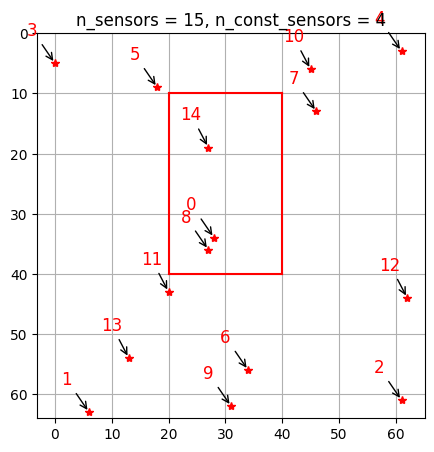

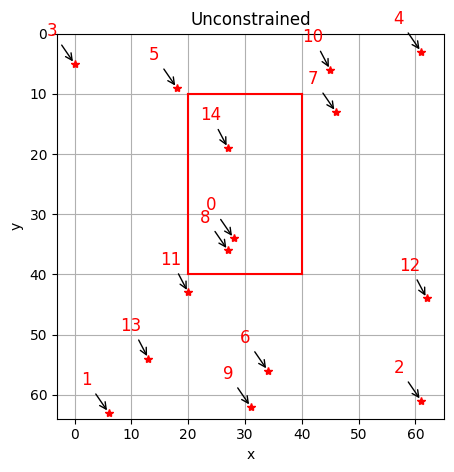

In [23]:
img = np.zeros(n_features)
img[top_sensors] = 16
plt.figure(figsize=(5,5))
plt.plot(xTopConstMax,yTopConstMax,'*r')
plt.plot([xmin,xmin],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymax,ymax],'r')
plt.plot([xmax,xmax],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymin,ymin],'r')
plt.ylim([64,0])
plt.title('n_sensors = {}, n_const_sensors = {}'.format(n_sensors,n_const_sensors_max))
for ind,i in enumerate(range(len(xTopConstMax))):
    plt.annotate(f"{str(ind)}",(xTopConstMax[i],yTopConstMax[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))
plt.grid()
plt.show()

plt.figure(figsize=(5,5))
plt.plot(xTopUnc, yTopUnc,'*r')
plt.plot([xmin,xmin],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymax,ymax],'r')
plt.plot([xmax,xmax],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymin,ymin],'r')
plt.title('Unconstrained')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([64,0])
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))
plt.grid()
plt.show()

### Conclusions: 

When there are fewer than (n_const_sensors_max) in the constrained region, max_n will only place three in the constrained region even though the user allows a max of 4,5 .. to be placed. 

## The predetermined case: 

- This occurs when (n_pre_sensors) locations are already specified and we want the best locations to place the remaining sensors. 

#### Suppose two sensor locations are already specified (sen1 at $x = 10$ and $y =7$), (sen2 at $x = 25$ and $y = 30$). We optimize placement of the remaining sensors. 

In [24]:
# Convert pixel coordinates into sensor locations (column ID's)

predetermined_sensorsy = np.array([10, 7])
predetermined_sensorsx = np.array([25, 30])
predetermined_sensors_array = np.stack((predetermined_sensorsy, predetermined_sensorsx), axis=1)
predetermined_sensors_tuple = np.transpose(predetermined_sensors_array)
idx_predetermined = np.ravel_multi_index(predetermined_sensors_tuple, (image_shape[0],image_shape[1]))
print('The predetermined sensor locations (Column IDs) are: {}'.format(idx_predetermined))

The predetermined sensor locations (Column IDs) are: [665 478]


Text(0.5, 1.0, 'Predetermined sensor locations')

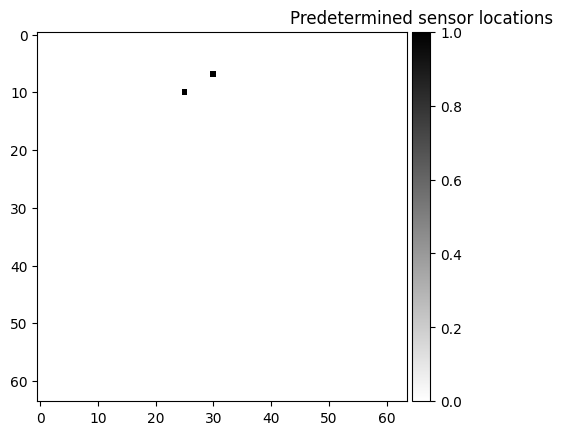

In [25]:
ax = plt.subplot()
#Plot predetermined sensor locations 

img = np.zeros(n_features)
img[idx_predetermined] = 1
im = plt.imshow(img.reshape(image_shape),cmap=plt.cm.binary)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.title('Predetermined sensor locations')

In [26]:
# Print the predetermined sen1 column index and its corrsponding pixel coordinates (x,y)

x0,y0 = np.mod(idx_predetermined[0],np.sqrt(n_features)),np.floor(idx_predetermined[0]/np.sqrt(n_features))
print(idx_predetermined[0],x0,y0)

665 25.0 10.0


In [27]:
# Define the number of predetermined sensors allowed (s)

n_pre_sensors = 2
# Define the GQR predtermined optimizer

optimizer_pre = ps.optimizers.GQR()
opt_pre_kws={'idx_constrained':idx_predetermined,
         'n_sensors':n_sensors,
         'n_const_sensors':n_pre_sensors,
         'all_sensors':all_sensors,
         'constraint_option':"predetermined"}

basis_pre = ps.basis.SVD(n_basis_modes=n_sensors)

In [28]:
# Initialize and fit the model

model_pre = ps.SSPOR(basis = basis_pre, optimizer = optimizer_pre, n_sensors = n_sensors)
model_pre.fit(X_train,**opt_pre_kws)

# sensor locations based on columns of the data matrix
top_sensors_pre = model_pre.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstPre = np.mod(top_sensors_pre,np.sqrt(n_features))
yTopConstPre = np.floor(top_sensors_pre/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_pre))

The list of sensors selected is: [2204 4038 3965  320  253  594 3618  878 2331 3999  429 2772 2878  478
  665]


Display the unconstrained and predetermined (purple dots) sensor locations on the grid using GQR predetermined optimizer.

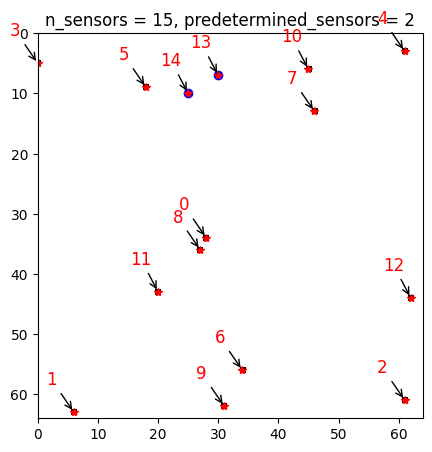

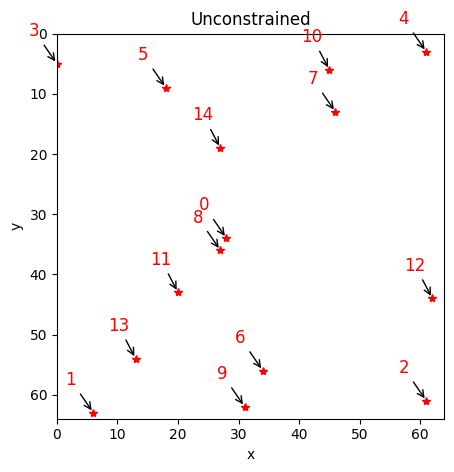

In [29]:
yPredetermined = np.floor(top_sensors_pre/np.sqrt(n_features))
xPredetermined = np.mod(top_sensors_pre,np.sqrt(n_features))

img = np.zeros(n_features)
img[top_sensors_pre] = 16
plt.figure(figsize=(5,5))
plt.plot(xPredetermined,yPredetermined,'*r')
plt.imshow(img.reshape(image_shape),cmap=plt.cm.binary)
plt.scatter(predetermined_sensorsx, predetermined_sensorsy, color = 'b')
plt.xlim([0,64])
plt.ylim([64,0])
plt.title('n_sensors = {}, predetermined_sensors = {}'.format(n_sensors,n_pre_sensors))
for ind,i in enumerate(range(len(xPredetermined))):
    plt.annotate(f"{str(ind)}",(xPredetermined[i],yPredetermined[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))
plt.show()

image = np.zeros(n_features)
image[top_sensors] = 16
plt.figure(figsize=(5,5))
plt.plot(xTopUnc, yTopUnc,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0,64])
plt.ylim([64,0])
plt.title('Unconstrained')
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))
plt.show()

Compare sensor indices and pixel coordinates for unconstrained and predetermined sensor placement

In [30]:
columns = ['Sensor ID','UncX','UncY','Sensor ID','XConst','YConst']
ConstrainedSensors_df = pd.DataFrame(data = np.vstack([top_sensors,xTopUnc,yTopUnc,top_sensors_pre,xPredetermined,yPredetermined]).T,columns=columns,dtype=int)
ConstrainedSensors_df.head(n_sensors)

,Sensor ID,UncX,UncY,Sensor ID,XConst,YConst
0,2204,28,34,2204,28,34
1,4038,6,63,4038,6,63
2,3965,61,61,3965,61,61
3,320,0,5,320,0,5
4,253,61,3,253,61,3
5,594,18,9,594,18,9
6,3618,34,56,3618,34,56
7,878,46,13,878,46,13
8,2331,27,36,2331,27,36
9,3999,31,62,3999,31,62


Plot the sensor locations (pixels) on the image for the unconstrained and predetermined case

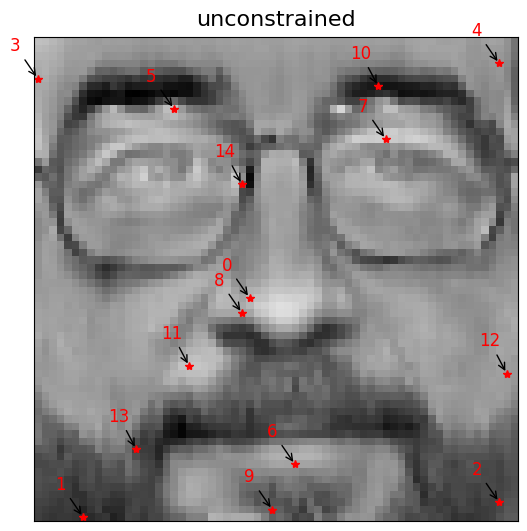

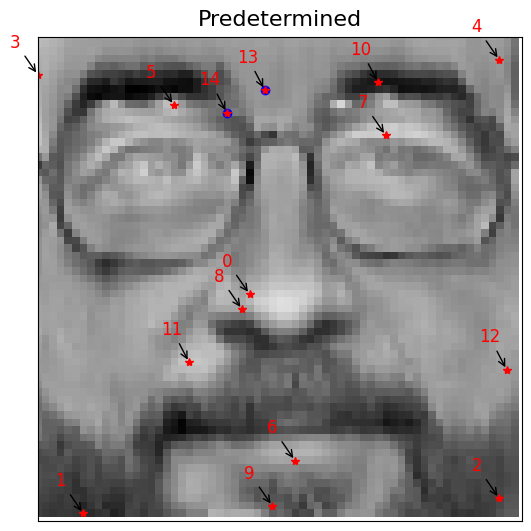

In [31]:
image = X[4,:].reshape(1,-1)

plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)

plt.plot(xTopUnc, yTopUnc,'*r')
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))


plot_gallery('Predetermined', image, n_col=1, n_row=1, cmap=plt.cm.gray)

plt.plot(xPredetermined, yPredetermined,'*r')
plt.scatter(predetermined_sensorsx, predetermined_sensorsy, color = 'b')
plt.xlim([0,64])
plt.ylim([64,0])
for ind,i in enumerate(range(len(xPredetermined))):
    plt.annotate(f"{str(ind)}",(xPredetermined[i],yPredetermined[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))
plt.show()

## Reconstruct image from test set using sensors placed via predetermined optimizer

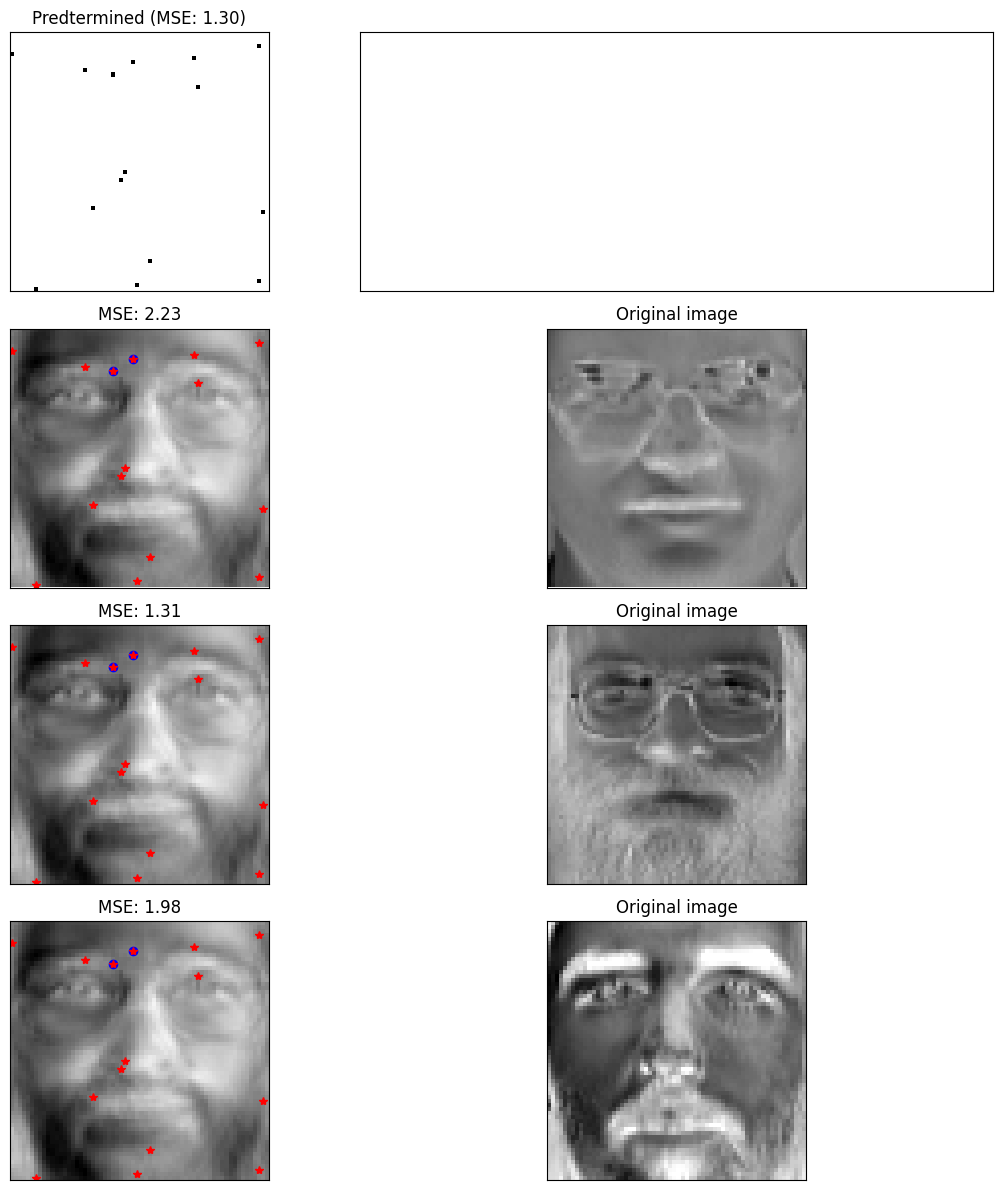

In [32]:
n_faces = 3
n_rows = n_faces + 1
n_cases = 1
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 3 * n_rows))

for k in range(n_cases):    
    # Get average reconstruction error across test set
    test_error = model_pre.reconstruction_error(X_test, sensor_range=[n_sensors])
    
    # Plot sensor locations

    axs[0, k].plot()
    axs[0, k].imshow(img.reshape(image_shape), cmap=plt.cm.binary)
    axs[0, k].set(title=f"Predtermined (MSE: {test_error[0]:.2f})")
   

    # Plot reconstructed faces
    for j in range(n_faces):
        idx = 10 * j
        img = model_pre.predict(X_test[idx, top_sensors_pre])
        vmax = max(img.max(), img.min())
        axs[j + 1, k].imshow(
            img.reshape(image_shape),
            cmap=plt.cm.binary,
            vmin=-vmax,
            vmax=vmax
        )
        yPredetermined = np.floor(top_sensors_pre/np.sqrt(n_features))
        xPredetermined = np.mod(top_sensors_pre,np.sqrt(n_features))
        axs[j + 1, k].plot(xPredetermined, yPredetermined,'*r')
        axs[j + 1,k].scatter(predetermined_sensorsx, predetermined_sensorsy, color = 'b')

        error = model_pre.reconstruction_error(X_test[idx], sensor_range=[n_sensors])[0]
        axs[j + 1, k].set(title=f"MSE: {error:.2f}")
        
        # Plot target image
        true_img = X_test[idx]
        vmax = max(true_img.max(), true_img.min())
        axs[j + 1, k + 1].imshow(
            true_img.reshape(image_shape),
            cmap=plt.cm.binary,
            vmin=-vmax,
            vmax=vmax
        )
        axs[j + 1, k + 1].set(title="Original image")
        

[ax.set(xticks=[], yticks=[]) for ax in axs.flatten()]
fig.tight_layout()

### Compare the reconstruction errors for unconstrained and predetermined sensor placement on the test set:

In [33]:
test_error_unconstrained = model_unconstrained.reconstruction_error(X_test, sensor_range=[n_sensors])
test_error_predetermined = model_pre.reconstruction_error(X_test, sensor_range=[n_sensors])
print("The reconstruction error for the unconstrained case is {}".format(test_error_unconstrained))
print("The reconstruction error for the predetermined case is {}".format(test_error_predetermined))

The reconstruction error for the unconstrained case is [0.12289169]
The reconstruction error for the predetermined case is [1.29847729]
